# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




In [31]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

from sklearn.metrics.pairwise import cosine_similarity

from wordcloud import WordCloud, STOPWORDS

import collections

from collections import OrderedDict

import math
import re

import pickle

from tqdm import tqdm_notebook as tqdm
import os

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [32]:
#sampling 100k data points for Logistic Regression Assignment.
df = pd.read_csv('final_preprocessed.csv').head(100000)
x = df['preprocessed_reviews']
print(x.shape)

(100000,)


# [4] Featurization

## [4.2] TF-IDF

In [34]:
tfidf_model = TfidfVectorizer(min_df=5)

tfidf_x = tfidf_model.fit_transform(x.values.astype('U'))

print(tfidf_x.shape)

(100000, 18101)


# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [40]:
sorted_idf = tfidf_model.idf_.argsort()
top_features = np.take(tfidf_model.get_feature_names(), sorted_idf)[:2000]
print(top_features)
print(top_features.shape)

['not' 'like' 'good' ... 'cranberry' 'grocer' 'comfort']
(2000,)


### [5.2] Calulation of Co-occurrence matrix

In [43]:
def co_occurence_matrix(data, word_list, window_size=None) :
    
    if window_size == None :
        window_size = 2
    
    list_of_sent = []
    co_occr_matrix = pd.DataFrame(np.zeros((len(word_list), len(word_list))),  index=top_features, columns=top_features)
    
    for sent in data:
        list_of_sent.append(sent.split())
        
    for sent in tqdm(list_of_sent):
        for index  in range(0, len(sent)):
            word = sent[index]
            if word in top_features:
                start=0
                end=0
                
                if (index - window_size) < 0 : 
                    start=0 
                else :
                    start = index - window_size
                
                if (index + window_size) >= len(sent) : 
                    end = len(sent) - 1
                else:
                    end = index + window_size
                
                window_words = list(np.take(sent, range(start,end+1)))
                window_words.remove(word)
               
                for window_word in window_words :
                    if window_word in top_features :
                        co_occr_matrix[word][window_word] += 1
                        
    for word in word_list :
        co_occr_matrix[word][word] = 0
             
    return co_occr_matrix

In [44]:
co_occr_mat = co_occurence_matrix(x, top_features, 2)
co_occr_mat.to_csv("co_occr_mat.csv")

In [45]:
co_occr_mat = pd.read_csv("co_occr_mat.csv", header=0, index_col=0)

### [5.3] Finding optimal value for number of components (n) to be retained.

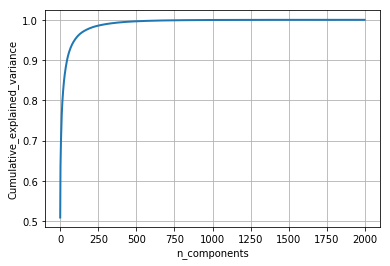

In [46]:
svd = TruncatedSVD(n_components = 1999)
svd_data = svd.fit_transform(co_occr_mat)

cum_var_explained = np.cumsum(svd.explained_variance_ratio_)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))

plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

300 omponents explains ~99% variance for above dataset.

In [47]:
svd = TruncatedSVD(n_components = 300)
svd_data = svd.fit_transform(co_occr_mat)

co_occur_mat_dash = pd.DataFrame(svd_data, index = top_features)

list_of_sent = []
for sent in x.values.astype('U'):
        list_of_sent.append(sent.split())

#Creating sentence representation dataset from above co_occurence_matrix
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list

for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    
    for word in sent: # for each word in a review/sentence
        if word in top_features:
            vec = co_occur_mat_dash.loc[word]
            sent_vec += vec
    
    sent_vectors.append(sent_vec)
    
x_dash = pd.DataFrame(sent_vectors)

### [5.4] Applying k-means clustering

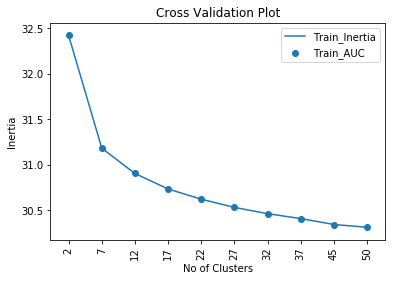

In [48]:
n_clusters = [2, 7, 12, 17, 22, 27, 32, 37, 45, 50]
    
score = list()

for i in n_clusters :
    kmeans = KMeans(n_clusters = i, n_jobs=-1).fit(x_dash)
    score.append(np.log(kmeans.inertia_))

index = np.arange(len(n_clusters))
plt.plot(index, score, label = "Train_Inertia")
plt.scatter(index, score, label = "Train_AUC")
plt.xlabel("No of Clusters", fontsize=10)
plt.ylabel('Inertia', fontsize=10)
plt.legend()
plt.xticks(index, n_clusters, fontsize=10, rotation=90)
plt.title('Cross Validation Plot')
plt.show()

In [49]:
#from above cross-validation Plot, it can be seen that optimal no. of clusters are 10.
best_n_clusters = 10
kmeans_x = KMeans(n_clusters = best_n_clusters, n_jobs=-1).fit(x_dash)
print("Inertia on dataset: ", kmeans_x.inertia_)

Inertia on dataset:  28816501646063.76


### [5.5] Wordclouds of clusters obtained in the above section

Cluster No	Length of cluster
2		27317
6		26224
0		19240
9		12670
3		7601
1		4166
7		1926
4		673
8		147
5		36
Enter the cluster nos. to print Wordclouds :2 9 5

Wordcloud for cluster no. 2 having 27317 points : 


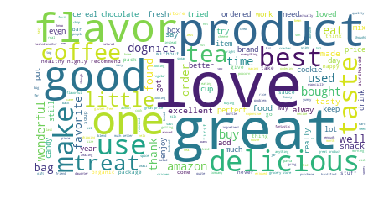


Wordcloud for cluster no. 9 having 12670 points : 


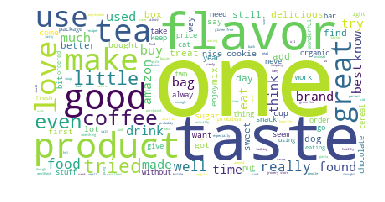


Wordcloud for cluster no. 5 having 36 points : 


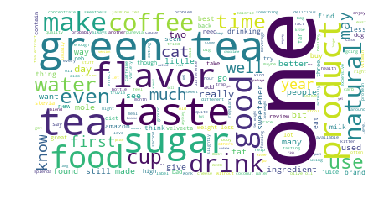

In [50]:
labels = list(kmeans_x.labels_)
d = {}

for i in range(0, len(labels)) :
    key = labels[i]
    value = i
    if key in d:
        d[key].append(value)
    else:
        d[key] = [value]

new_dict = OrderedDict(sorted(d.items(), key=lambda t: len(t[1]), reverse=True))

print("Cluster No\tLength of cluster")
for k, v in new_dict.items() :
    print(str(k) + "\t\t"+ str(len(new_dict[k])))
    
wc_clus = list(map(int, input("Enter the cluster nos. to print Wordclouds :").rstrip().split()))
    
for i in wc_clus :
    print("\nWordcloud for cluster no. %d having %d points : " %(i, len(new_dict[i])))
    s = ""
    sentences = x.iloc[new_dict[i]]
        
    for sentence in sentences :
        s = s + sentence + " "

    wordcloud = WordCloud(background_color ='white').generate(s)
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.show()

### [5.6] Function that returns most similar words for a given word.

In [53]:
# Please write all the code with proper documentation

cos_similarity_df = pd.DataFrame(cosine_similarity(co_occur_mat_dash), index=top_features, columns=top_features)

def fn_similar_words(word) :
    similar_words = []
    
    if word in top_features: 
        sorted_similar_word_array = cos_similarity_df[word].argsort()
        similar_words = list(np.take(cos_similarity_df.columns, sorted_similar_word_array)[-20:-1])
        print("Simalar words to %s are :" %(word))
        print(similar_words)
    else :
        print("Word Not Found!")

In [54]:
fn_similar_words("love")
print("\n")
fn_similar_words("good")
print("\n")
fn_similar_words("coffee")

Simalar words to love are :
['however', 'experience', 'prefer', 'good', 'truly', 'type', 'indeed', 'fine', 'addicted', 'incredible', 'yummy', 'loved', 'wonderful', 'enjoy', 'delicious', 'awesome', 'fantastic', 'fabulous', 'amazing']


Simalar words to good are :
['although', 'palate', 'course', 'great', 'disappointing', 'disgusting', 'horrible', 'gross', 'fantastic', 'however', 'incredible', 'yummy', 'terrible', 'fine', 'awesome', 'ok', 'impressed', 'amazing', 'like']


Simalar words to coffee are :
['popcorn', 'produce', 'things', 'one', 'actually', 'fact', 'gum', 'generally', 'mints', 'coffees', 'taste', 'course', 'really', 'anyway', 'however', 'flavor', 'kind', 'also', 'still']


# [6] Conclusions

1. Implementation of co-occurence matrix for words in the datatset gives the associativity between the words in given courpus.
2. Truncated SVD helped to minimize this matrix to minimal number of optimal components here 300.
3. With the help of above word embeddings we created sentence vectors for each review which then used for clustering.
4. No. Of optimal Clusters = 10.
5. We could see from wordclouds that for almost every cluster some words like "love", "one", "great" and "best" are common. 